# 04-linear-&-logistic-regression

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from ucimlrepo import fetch_ucirepo 

___ 
## 1. Business Understanding

Goal:
1. Linear Regression Model:
    - Construct a linear regression model for predicting house prices, with the ``"Y house price of unit area"`` as the continuous target in the dataset.
2. Logistic Regression Model:
    - Convert the target variable into a binary-valued label based on whether the price is above or below the training set mean, then train a logistic regression classifier to predict that label.


___ 
## 2. Data Understanding

In [63]:
# fetch the dataset 
real_estate_valuation = fetch_ucirepo(id=477) 

df = real_estate_valuation.data.original
df = df.drop(columns="No")

# basic info
df.shape
df.columns
df.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [64]:
# target stats
target = "Y house price of unit area"
print("Target statistics:")
print(df[target].describe())
print("Targets median: ", df[target].median())
print("Target max-min: ", df[target].max() - df[target].min())

Target statistics:
count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: Y house price of unit area, dtype: float64
Targets median:  38.45
Target max-min:  109.9


Plotting the data for visualization. 
- X-axel: Each of the columns, except the target ("Y house price of unit area")
- Y-axel: ("Y house price of unit area")

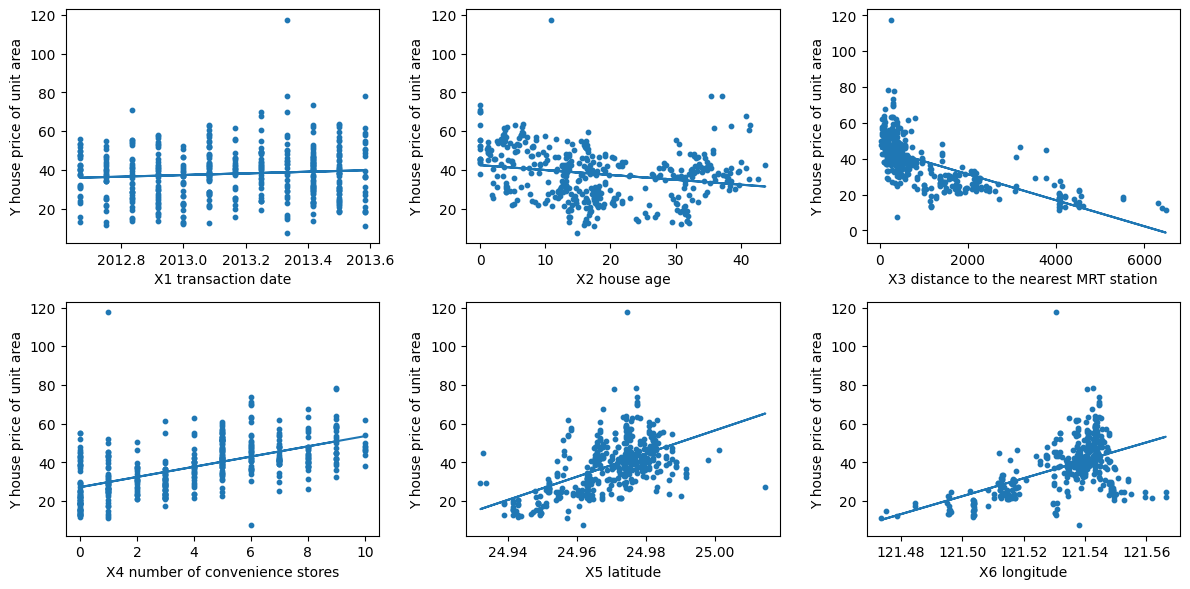

In [65]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()
target = "Y house price of unit area"

# For each column except the target.
for i in range(6):
    X = df.iloc[:, i] 
    y = df[target]
    ax[i].scatter(df.iloc[:, i], y, s=10)
    
    m, b = np.polyfit(X, y, 1) # linear regression line with a degree 1 polynomial
    ax[i].plot(X, m * X + b) # draws the regression line on top of the scatter
    ax[i].set_ylabel(target)
    ax[i].set_xlabel(df.columns[i])

plt.tight_layout()
plt.show()

**Understanding data from the visualization:**

(Y-axis is represented as: $y \times 10000$ per Ping, where $1\ \text{Ping} = 3.3\ \mathrm{m}^2$)

$\text{Price per }\mathrm{m}^2 = \frac{y \cdot 10000}{3.3}$

- **X1:** Housing prices do not appear to drastically change based on transaction dates, which we can see from the near-flat regression line.
- **X2:** The age has a slight negative impact on the pricing, with noticeable differences starting at around the 15 year mark. At around the 35 year mark the price starts to rebound again, which makes the regression line trend only slightly into the negatives.
- **X3:** Proximity to public transportation appears to have a strong impact on housing prices. Homes located near MRT stations mostly fall within the 38–58 price range, while prices drop into the 20s as distance increases.
- **X4:** The number of nearby convenience stores appears strongly related to housing prices. The relationship shows a positive, near-linear trend.
- **X5/X6:** Latitude and Longitude show a strong near-linear relationship with housing prices till a certain lat/lon value, where the housing gets more sparse. This is possibly due to climate and coastal differences.

___ 
## 3. Data Preparation


Preparation of the data:
- Defining features and target.
- Train and test data splitting.

In [66]:
# 1) features and target
X = df.drop(columns=[target])
y = df[target]

# 2) train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 3) standardized features (fit on train only)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

___ 
## 4.1 Modeling (Linear Regression)

In [67]:
# Train linear regression on standardized features
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
# We get predictions for datasets for comparisons
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

___ 
## 4.2 Modeling (Logistic Regression)

___ 
## 5. Evaluation



### Importance (influence) of variables
Because the linear regression was trained on **standardized features**, the coefficient magnitudes are directly comparable across variables.

So each $b_i$ means: **the expected change in price (per unit area) for a 1 standard deviation increase** in that variable (holding the others constant).
- **Sign**: positive increases predicted price; negative decreases it.
- **Magnitude**: larger $|b_i|$ means stronger influence in this model.

From the coefficient ranking printed in the next cell (sorted by $|b_i|$):
- **X3 distance to the nearest MRT station** has the largest (negative) influence: farther from MRT == lower predicted price.
- **X4 number of convenience stores** is strongly positive: more nearby stores == higher predicted price.
- **X2 house age** (negative): older houses tend to have lower predicted price.
- **X5 latitude** has a great positive influence: coastal == higher predicted price
- **X1 transaction date** is positive, but has a weaker influence in comparison to other variables; 
- **X6 longitude** is small and negative in comparison to latitude.


In [68]:
importance = pd.Series(model.coef_, index=X.columns).sort_values(key=abs, ascending=False)
print(importance)

X3 distance to the nearest MRT station   -6.066970
X4 number of convenience stores           3.154872
X2 house age                             -3.004869
X5 latitude                               2.735558
X1 transaction date                       1.503231
X6 longitude                             -0.403082
dtype: float64


In [69]:
# TRAIN METRICS
r2_train = r2_score(y_train, train_preds)
mae_train = mean_absolute_error(y_train, train_preds)
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))

# TEST METRICS
r2_test = r2_score(y_test, test_preds)
mae_test = mean_absolute_error(y_test, test_preds)
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print("TRAIN")
print(f"R2: {r2_train}, MAE: {mae_train}, RMSE: {rmse_train}")

print(f"\nTEST")
print(f"R2: {r2_test}, MAE: {mae_test}, RMSE: {rmse_test}")


TRAIN
R2: 0.5494715970830404, MAE: 6.497490513067943, RMSE: 9.37732820046947

TEST
R2: 0.6730841815500264, MAE: 5.345875758387667, RMSE: 7.233509252792137


___ 
## 6. Deployment

